In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Jane Eyre, Bronte",54.754599,6.844325,13.408364,8
Azure Functions + Visual Studio,306.659666,61.331933,92.011740,5
Email Auth and Security,347.903553,43.487944,75.604940,8
Debugging in VS Code,624.986826,56.816984,101.338939,11
Logging in Python,764.466642,54.604760,125.576727,14
Azure AD Authentication,779.417467,59.955190,140.274336,13
Azure Private DNS,807.859975,42.518946,84.887981,19
RAG Project,923.044922,57.690308,115.169879,16
C# Basics,1011.898641,32.641892,52.925856,31
VMWare,1116.795520,25.971989,38.348779,43


# Histogram

sum of ages: ~32172.43


<Axes: >

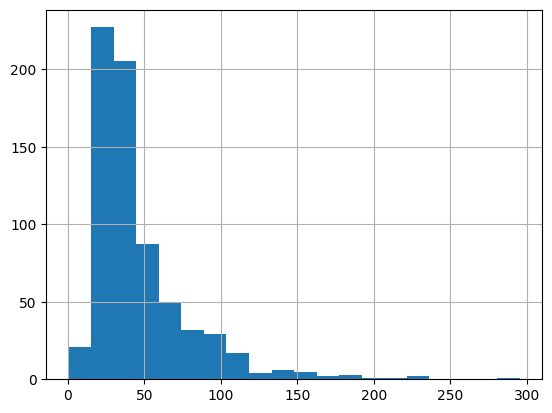

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [8]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [10]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [11]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 693
Total card age: 32172.43


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
231,Azure Functions + Visual Studio,ASP.NET offers several state management techni...,0a2b8144d1d299a28fb76170d854ba38,-92.011740,-61.331933,92.011740,306.659666,0.673711,0,0
690,Azure Functions + Visual Studio,ASP.NET supports caching to improve performanc...,d07e000e7e940a925efa25a451e9ab3f,-49.451847,-61.331933,92.011740,306.659666,0.673711,3,0
214,Azure AD Authentication,"Built-In Roles\nPredefined roles like Owner, C...",07438f0669237f7f9ade8e2be9c0c6e1,-140.274336,-59.955190,140.274336,779.417467,0.807781,0,0
215,Azure AD Authentication,"Role Assignment\nLinks a principal (user, grou...",f445b4bb29b65e4bfdc8ae15101622af,-62.295970,-59.955190,140.274336,779.417467,0.807781,3,0
450,Azure AD Authentication,Service Principal\nA security identity for an ...,a28d9e0df996c0ac0eb889d97e57ec4f,-44.437725,-59.955190,140.274336,779.417467,0.807781,6,0
217,Azure AD Authentication,Managed Identities\nAzure-managed identities u...,2ad76e64637c614682a8f5211278b094,-29.740621,-59.955190,140.274336,779.417467,0.807781,9,0
218,Azure AD Authentication,Azure AD Roles vs Azure Resource Roles\nAzure ...,6c6c1200236d748fc352faaaf8856bff,-19.388489,-59.955190,140.274336,779.417467,0.807781,12,0
159,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-232.835043,-59.762671,232.835043,1255.016099,0.147561,0,0
160,Azure Functions + PP365,Power Platform CLI\nA command-line interface t...,517d71c585ac6a335c1f885c6c7061a0,-77.340906,-59.762671,232.835043,1255.016099,0.147561,3,0
161,Azure Functions + PP365,Azure AD TokenRequestContext\nA context object...,993390e1c38b4a276d5672851695ac47,-57.647447,-59.762671,232.835043,1255.016099,0.147561,6,0


## Age Max

In [14]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
26,Azure Developer Associate,What are the two primary data types collected ...,f0995a4e3eae52ece78cb2f025efcf7f,-295.298804,-52.634911,295.298804,3842.348538,0.752287,0,0
159,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-232.835043,-59.762671,232.835043,1255.016099,0.147561,0,0
269,Azure Developer Associate,Which role grants least privilege to allow a u...,72ce544617e81069d717793d0c83d443,-229.694298,-52.634911,295.298804,3842.348538,0.752287,1,1
51,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-208.736450,-55.638252,208.736450,3338.295112,0.578010,0,0
397,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-196.497540,-59.762671,232.835043,1255.016099,0.147561,1,1
293,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,-190.283905,-55.638252,208.736450,3338.295112,0.578010,1,1
114,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-185.896579,-58.999815,185.896579,1887.994094,0.389965,0,0
501,Azure Developer Associate,How does the Always restart policy differ from...,0858a8d05dbc45117b3d0f1dd538772b,-180.977296,-52.634911,295.298804,3842.348538,0.752287,2,2
27,Azure Developer Associate,What Azure Monitor feature routes platform log...,5208880711caac6907d82731a1e43cd9,-175.340839,-52.634911,295.298804,3842.348538,0.752287,3,0
85,Asynchronous Python,Lock (Mutex)\nA lock is a synchronization prim...,2218c022e468947a8bbd7ec0626cfe1e,-168.404211,-49.399123,168.404211,2272.359640,0.872635,0,0


In [18]:
existing_cards.head(10).sum()

head                   Azure Functions + Visual StudioAzure Functions...
body                   ASP.NET offers several state management techni...
hash                   0a2b8144d1d299a28fb76170d854ba38d07e000e7e940a...
age                                                          -805.424122
subject_mean_age                                             -601.727829
subject_highest_age                                          1583.900287
subject_age_sum                                              8275.454965
head_random_roll                                                5.829011
count                                                                 42
n_fold                                                                 0
dtype: object

In [19]:
existing_cards['age'].mean()

-46.42486528811707